In [17]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from datetime import datetime

from utils import FaceKeypointDataset, get_train_transforms, get_validation_transforms, visualize_augmented_samples, visualize_inference, train
from model.network import Net

In [18]:
# Load processed annotations
annotations_path  = 'data/Annotations/processed_annotations.csv'
annotations = pd.read_csv(annotations_path)
images_dir = 'data/Images_Processed'

In [19]:
def visualize_dataset_samples(dataset, num_samples=5):
    """
    Visualizes a specified number of samples from the dataset with keypoints overlaid.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to visualize samples from.
        num_samples (int): Number of samples to visualize.
    """
    plt.figure(figsize=(15, 3 * num_samples))
    for i in range(num_samples):
        sample = dataset[i]
        if sample is None:
            continue
        image, keypoints = sample
        
        # If the image is a tensor, convert it to a numpy array
        if isinstance(image, torch.Tensor):
            image_np = image.numpy().transpose((1, 2, 0))
            # Unnormalize if the image was normalized during preprocessing
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = std * image_np + mean
            image_np = np.clip(image_np, 0, 1)
        elif isinstance(image, np.ndarray):
            image_np = image
        else:
            # Assume image is a PIL Image
            image_np = np.array(image)
        
        # Reshape keypoints to (num_keypoints, 2)
        keypoints = keypoints.numpy().reshape(-1, 2)
        
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(image_np)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', s=20, marker='x')
        plt.axis('off')
        plt.title(f"Sample {i+1}")
    
    plt.tight_layout()
    plt.show()


In [20]:
train_transforms = get_train_transforms()
val_transforms = get_validation_transforms()

c:\Users\first\Desktop\GithubForSchool\face-keypoint-detection\.venv\Lib\site-packages\albumentations\core\validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
c:\Users\first\Desktop\GithubForSchool\face-keypoint-detection\.venv\Lib\site-packages\albumentations\core\composition.py:250: UserWarning: Got processor for keypoints, but no transform to process it.
  self._set_keys()


In [21]:
full_dataset = FaceKeypointDataset(
        annotations=annotations,
        root_dir=images_dir,
        transform=train_transforms
    )

In [22]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [23]:
val_dataset.dataset.transform = val_transforms

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [24]:
# Initialize model
model = Net()

In [25]:
# Define loss function and optimizer
criterion_keypoints = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [26]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

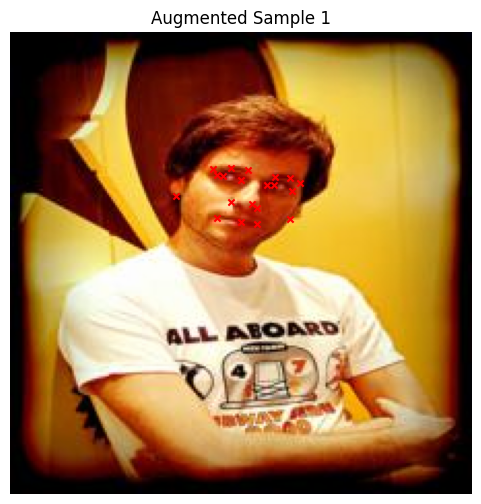

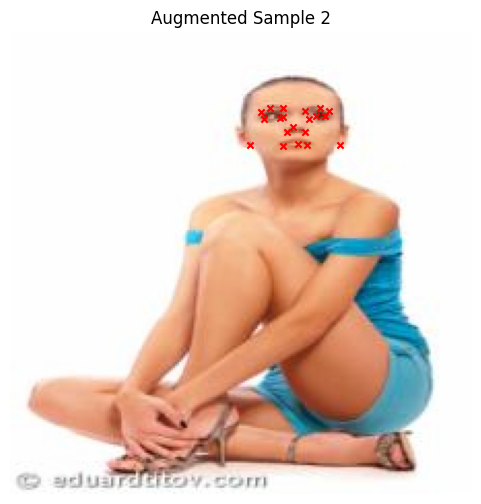

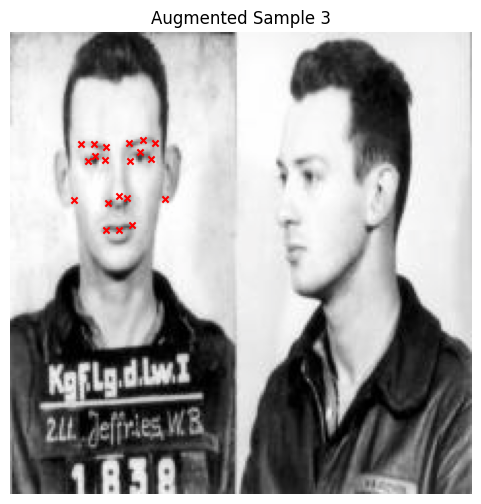

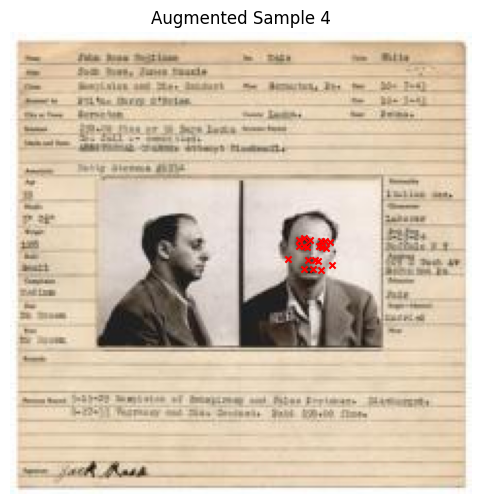

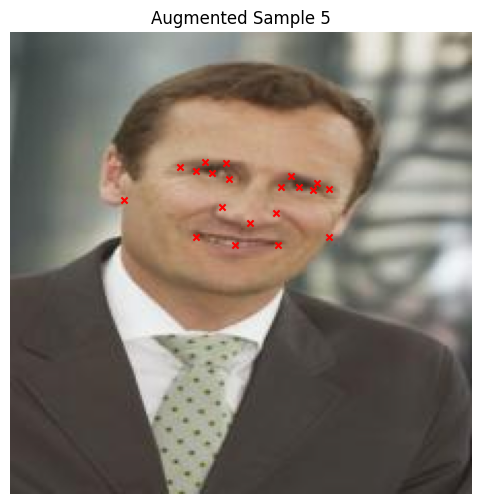

In [28]:
visualize_augmented_samples(train_dataset, num_samples=5)

In [29]:
# Start training
trained_model, results_df = train(model, 
                      criterion_keypoints, 
                      optimizer, 
                      scheduler, 
                      train_loader, 
                      val_loader, 
                      epochs=100, 
                      device=device, 
                      patience=10)

Epoch 1/100 | Train Loss: 0.0952 | Val Loss: 0.0224
Validation loss decreased. Saving model...


Epoch 2/100 | Train Loss: 0.0421 | Val Loss: 0.0253
No improvement in validation loss for 1 epoch(s).


Epoch 3/100 | Train Loss: 0.0350 | Val Loss: 0.0224
Validation loss decreased. Saving model...


Epoch 4/100 | Train Loss: 0.0312 | Val Loss: 0.0209
Validation loss decreased. Saving model...


Epoch 5/100 | Train Loss: 0.0294 | Val Loss: 0.0210
No improvement in validation loss for 1 epoch(s).


Epoch 6/100 | Train Loss: 0.0271 | Val Loss: 0.0188
Validation loss decreased. Saving model...


Epoch 7/100 | Train Loss: 0.0265 | Val Loss: 0.0198
No improvement in validation loss for 1 epoch(s).


Epoch 8/100 | Train Loss: 0.0255 | Val Loss: 0.0180
Validation loss decreased. Saving model...


Epoch 9/100 | Train Loss: 0.0238 | Val Loss: 0.0174
Validation loss decreased. Saving model...


Epoch 10/100 | Train Loss: 0.0232 | Val Loss: 0.0184
No improvement in validation loss for 1 epoch(s).


Epoch 11/100 | Train Loss: 0.0225 | Val Loss: 0.0195
No improvement in validation loss for 2 epoch(s).


Epoch 12/100 | Train Loss: 0.0220 | Val Loss: 0.0174
No improvement in validation loss for 3 epoch(s).


Epoch 13/100 | Train Loss: 0.0206 | Val Loss: 0.0167
Validation loss decreased. Saving model...


Epoch 14/100 | Train Loss: 0.0209 | Val Loss: 0.0167
Validation loss decreased. Saving model...


Epoch 15/100 | Train Loss: 0.0199 | Val Loss: 0.0169
No improvement in validation loss for 1 epoch(s).


Epoch 16/100 | Train Loss: 0.0189 | Val Loss: 0.0169
No improvement in validation loss for 2 epoch(s).


Epoch 17/100 | Train Loss: 0.0185 | Val Loss: 0.0173
No improvement in validation loss for 3 epoch(s).


Epoch 18/100 | Train Loss: 0.0183 | Val Loss: 0.0156
Validation loss decreased. Saving model...


Epoch 19/100 | Train Loss: 0.0170 | Val Loss: 0.0153
Validation loss decreased. Saving model...


Epoch 20/100 | Train Loss: 0.0168 | Val Loss: 0.0152
Validation loss decreased. Saving model...


Epoch 21/100 | Train Loss: 0.0157 | Val Loss: 0.0162
No improvement in validation loss for 1 epoch(s).


Epoch 22/100 | Train Loss: 0.0159 | Val Loss: 0.0147
Validation loss decreased. Saving model...


Epoch 23/100 | Train Loss: 0.0149 | Val Loss: 0.0138
Validation loss decreased. Saving model...


Epoch 24/100 | Train Loss: 0.0149 | Val Loss: 0.0150
No improvement in validation loss for 1 epoch(s).


Epoch 25/100 | Train Loss: 0.0136 | Val Loss: 0.0153
No improvement in validation loss for 2 epoch(s).


Epoch 26/100 | Train Loss: 0.0133 | Val Loss: 0.0134
Validation loss decreased. Saving model...


Epoch 27/100 | Train Loss: 0.0124 | Val Loss: 0.0158
No improvement in validation loss for 1 epoch(s).


Epoch 28/100 | Train Loss: 0.0126 | Val Loss: 0.0145
No improvement in validation loss for 2 epoch(s).


Epoch 29/100 | Train Loss: 0.0122 | Val Loss: 0.0139
No improvement in validation loss for 3 epoch(s).


Epoch 30/100 | Train Loss: 0.0114 | Val Loss: 0.0131
Validation loss decreased. Saving model...


Epoch 31/100 | Train Loss: 0.0110 | Val Loss: 0.0138
No improvement in validation loss for 1 epoch(s).


Epoch 32/100 | Train Loss: 0.0102 | Val Loss: 0.0129
Validation loss decreased. Saving model...


Epoch 33/100 | Train Loss: 0.0098 | Val Loss: 0.0122
Validation loss decreased. Saving model...


Epoch 34/100 | Train Loss: 0.0098 | Val Loss: 0.0127
No improvement in validation loss for 1 epoch(s).


Epoch 35/100 | Train Loss: 0.0098 | Val Loss: 0.0127
No improvement in validation loss for 2 epoch(s).


Epoch 36/100 | Train Loss: 0.0094 | Val Loss: 0.0124
No improvement in validation loss for 3 epoch(s).


Epoch 37/100 | Train Loss: 0.0093 | Val Loss: 0.0130
No improvement in validation loss for 4 epoch(s).


Epoch 38/100 | Train Loss: 0.0085 | Val Loss: 0.0122
No improvement in validation loss for 5 epoch(s).


Epoch 39/100 | Train Loss: 0.0088 | Val Loss: 0.0133
No improvement in validation loss for 6 epoch(s).


Epoch 40/100 | Train Loss: 0.0081 | Val Loss: 0.0123
No improvement in validation loss for 7 epoch(s).


Epoch 41/100 | Train Loss: 0.0077 | Val Loss: 0.0121
Validation loss decreased. Saving model...


Epoch 42/100 | Train Loss: 0.0076 | Val Loss: 0.0121
Validation loss decreased. Saving model...


Epoch 43/100 | Train Loss: 0.0074 | Val Loss: 0.0122
No improvement in validation loss for 1 epoch(s).


Epoch 44/100 | Train Loss: 0.0074 | Val Loss: 0.0122
No improvement in validation loss for 2 epoch(s).


Epoch 45/100 | Train Loss: 0.0073 | Val Loss: 0.0122
No improvement in validation loss for 3 epoch(s).


Epoch 46/100 | Train Loss: 0.0073 | Val Loss: 0.0121
No improvement in validation loss for 4 epoch(s).


Epoch 47/100 | Train Loss: 0.0071 | Val Loss: 0.0122
No improvement in validation loss for 5 epoch(s).


Epoch 48/100 | Train Loss: 0.0072 | Val Loss: 0.0121
Validation loss decreased. Saving model...


Epoch 49/100 | Train Loss: 0.0073 | Val Loss: 0.0121
Validation loss decreased. Saving model...


Epoch 50/100 | Train Loss: 0.0071 | Val Loss: 0.0123
No improvement in validation loss for 1 epoch(s).


Epoch 51/100 | Train Loss: 0.0070 | Val Loss: 0.0120
Validation loss decreased. Saving model...


Epoch 52/100 | Train Loss: 0.0069 | Val Loss: 0.0122
No improvement in validation loss for 1 epoch(s).


Epoch 53/100 | Train Loss: 0.0070 | Val Loss: 0.0122
No improvement in validation loss for 2 epoch(s).


Epoch 54/100 | Train Loss: 0.0069 | Val Loss: 0.0122
No improvement in validation loss for 3 epoch(s).


Epoch 55/100 | Train Loss: 0.0069 | Val Loss: 0.0120
Validation loss decreased. Saving model...


Epoch 56/100 | Train Loss: 0.0068 | Val Loss: 0.0121
No improvement in validation loss for 1 epoch(s).


Epoch 57/100 | Train Loss: 0.0067 | Val Loss: 0.0119
Validation loss decreased. Saving model...


Epoch 58/100 | Train Loss: 0.0066 | Val Loss: 0.0120
No improvement in validation loss for 1 epoch(s).


Epoch 59/100 | Train Loss: 0.0065 | Val Loss: 0.0119
No improvement in validation loss for 2 epoch(s).


Epoch 60/100 | Train Loss: 0.0066 | Val Loss: 0.0120
No improvement in validation loss for 3 epoch(s).


Epoch 61/100 | Train Loss: 0.0067 | Val Loss: 0.0122
No improvement in validation loss for 4 epoch(s).


Epoch 62/100 | Train Loss: 0.0065 | Val Loss: 0.0121
No improvement in validation loss for 5 epoch(s).


Epoch 63/100 | Train Loss: 0.0065 | Val Loss: 0.0120
No improvement in validation loss for 6 epoch(s).


Epoch 64/100 | Train Loss: 0.0065 | Val Loss: 0.0121
No improvement in validation loss for 7 epoch(s).


Epoch 65/100 | Train Loss: 0.0066 | Val Loss: 0.0121
No improvement in validation loss for 8 epoch(s).


Epoch 66/100 | Train Loss: 0.0066 | Val Loss: 0.0121
No improvement in validation loss for 9 epoch(s).


Epoch 67/100 | Train Loss: 0.0064 | Val Loss: 0.0121
No improvement in validation loss for 10 epoch(s).
Early stopping triggered!


In [30]:
results_df.to_csv('training_results.csv', index=False)

In [31]:
def visualize_inference(model, dataset, device='cuda', num_samples=5):
    """
    Performs inference on a specified number of test samples and visualizes the predicted keypoints.

    Args:
        model (torch.nn.Module): Trained model.
        dataset (torch.utils.data.Dataset): The test dataset.
        device (str): Device to perform computations on ('cuda' or 'cpu').
        num_samples (int): Number of test samples to visualize.
    """
    model.to(device)
    model.eval()
    
    for i in range(num_samples):
        sample = dataset[i]
        if sample is None:
            print(f"Sample {i+1} is None. Skipping.")
            continue
        image, _ = sample  # Ignoring true_landmarks as per requirement
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():
            pred_keypoints = model(image_tensor)
        
        # Convert predicted keypoints to numpy array
        # Denormalize the predicted keypoints
        image_shape = image.shape[1:]  # Get the height and width of the image
        pred_keypoints = pred_keypoints.cpu().numpy().reshape(-1, 2)
        pred_keypoints[:, 0] = pred_keypoints[:, 0] * image_shape[1]  # Width
        pred_keypoints[:, 1] = pred_keypoints[:, 1] * image_shape[0]  # Height
        
        # Handle image tensor
        if isinstance(image, torch.Tensor):
            # Convert tensor to numpy array and transpose to HxWxC
            image_np = image.cpu().numpy().transpose((1, 2, 0))
        elif isinstance(image, np.ndarray):
            image_np = image
        else:
            # Assume image is a PIL Image
            image_np = np.array(image)
        
        plt.figure(figsize=(6,6))
        plt.imshow(image_np)
        
        # Plot predicted keypoints in red
        plt.scatter(pred_keypoints[:, 0], pred_keypoints[:, 1], c='r', s=20, marker='x', label='Predicted Keypoints')
        
        plt.title(f"Test Sample {i+1}")
        plt.axis('off')
        plt.legend()
        plt.show()


C:\Users\first\AppData\Local\Temp\ipykernel_17964\2150509748.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_keypoint_model.pth'))

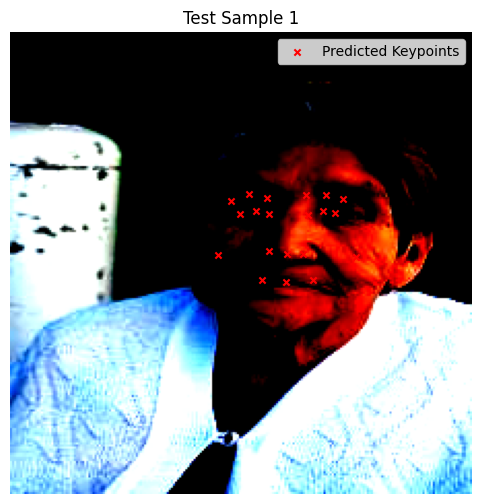

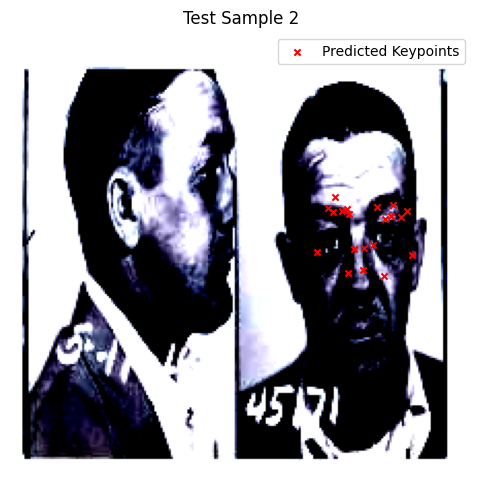

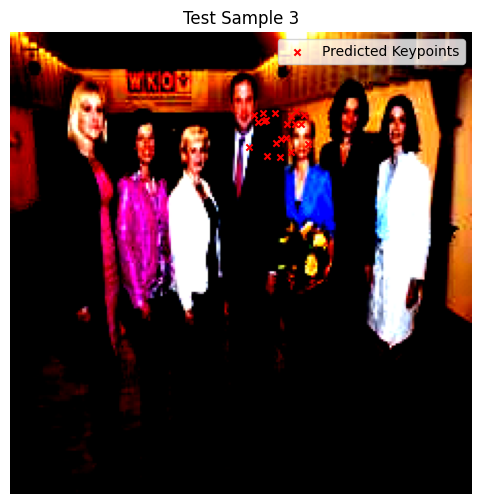

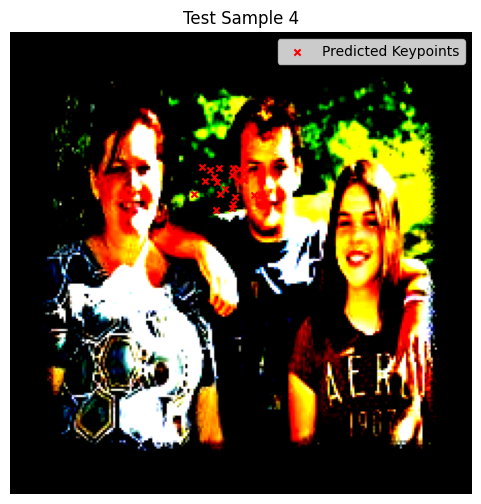

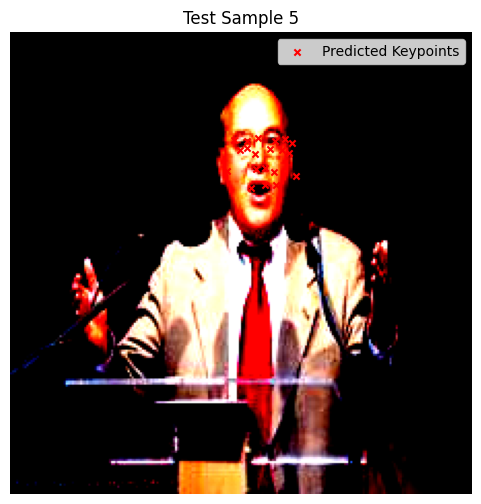

: 

In [32]:
model = Net()
model.load_state_dict(torch.load('best_keypoint_model.pth'))
visualize_inference(model, val_dataset, device='cuda', num_samples=5)